# Library

In [2]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import os

# Function

In [3]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

def masking(image):
    foreground_value = 255
    mask = np.uint8(image == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    image = np.zeros_like(image)
    image[labels == largest_label] = foreground_value
    ShowImage('image',image,'rgb')

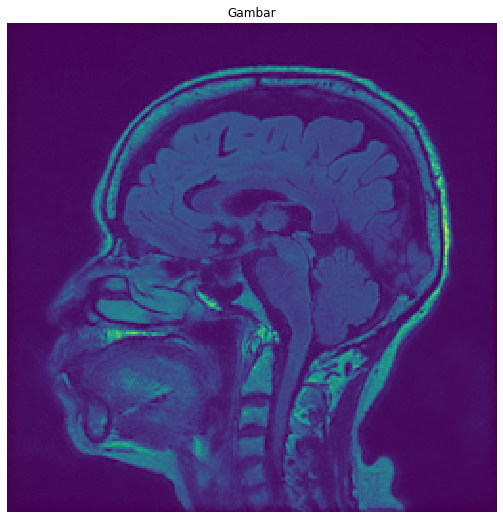

In [4]:
basepath ="../dicom/"
d = pydicom.read_file(basepath + "Z519")
file = np.array(d.pixel_array)
img = file
ShowImage('Gambar',img,'rgb')

In [5]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

# Otsu Thresholding

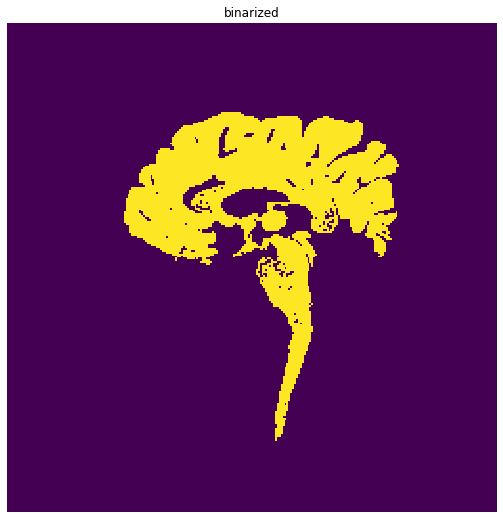

In [6]:
#OTSU THRESHOLDING
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

foreground_value = 255
mask = np.uint8(binarized == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
binarized = np.zeros_like(binarized)
binarized[labels == largest_label] = foreground_value
ShowImage('binarized',binarized,'rgb')

# Canny from Otsu

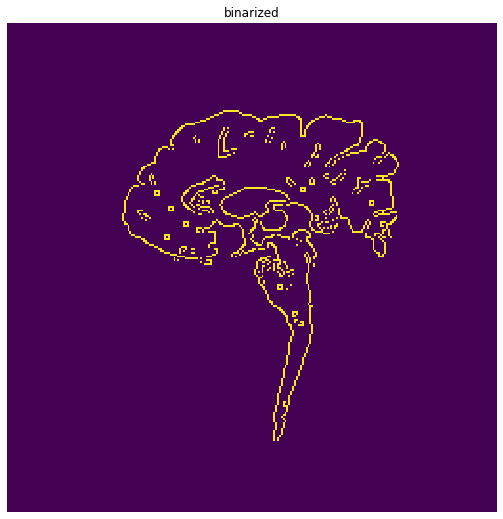

In [7]:
edges = cv2.Canny(binarized,100,200)
ShowImage('binarized',edges,'rgb')

# Closing from 

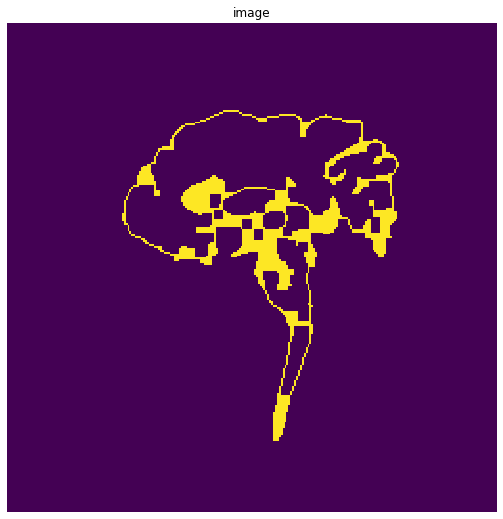

In [8]:
kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
masking(closing)

# Dilation from Closing

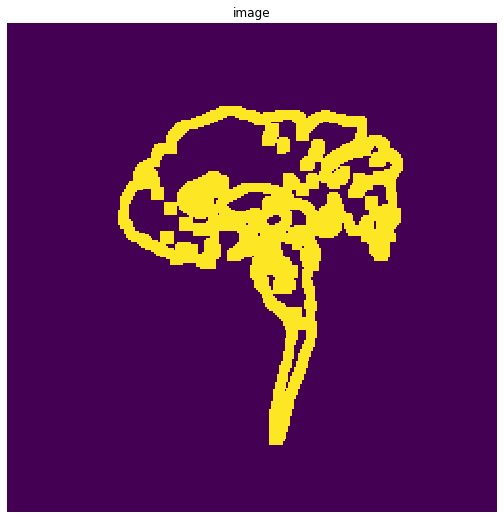

In [9]:
shape = np.ones((5, 5), np.uint8)
dilation_close = cv2.dilate(closing,shape,iterations = 1)
masking(dilation_close)

# Skull Stripping

In [10]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask = dilation_close)
brain_pixels = skull_stripped_image[dilation_close == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[14 13 10 ... 35 45 32] Brain Pixels
[[14.]
 [13.]
 [10.]
 ...
 [35.]
 [45.]
 [32.]] Kmeans Input
(3, 50, 0.01) criteria Paramaters
(8061, 1) K-means segmentation


# Segmented Image

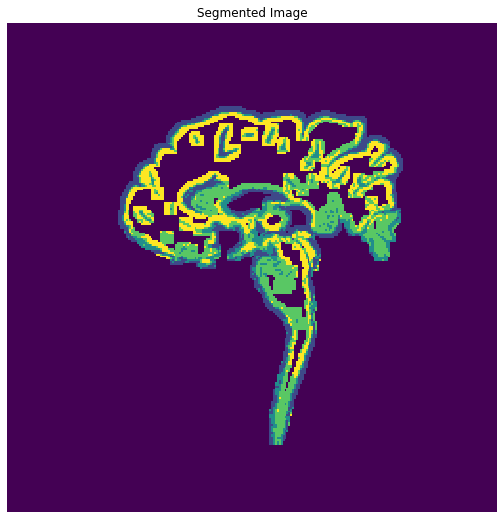

In [11]:
segmented_image = np.zeros_like(dilation_close)
segmented_image[dilation_close == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

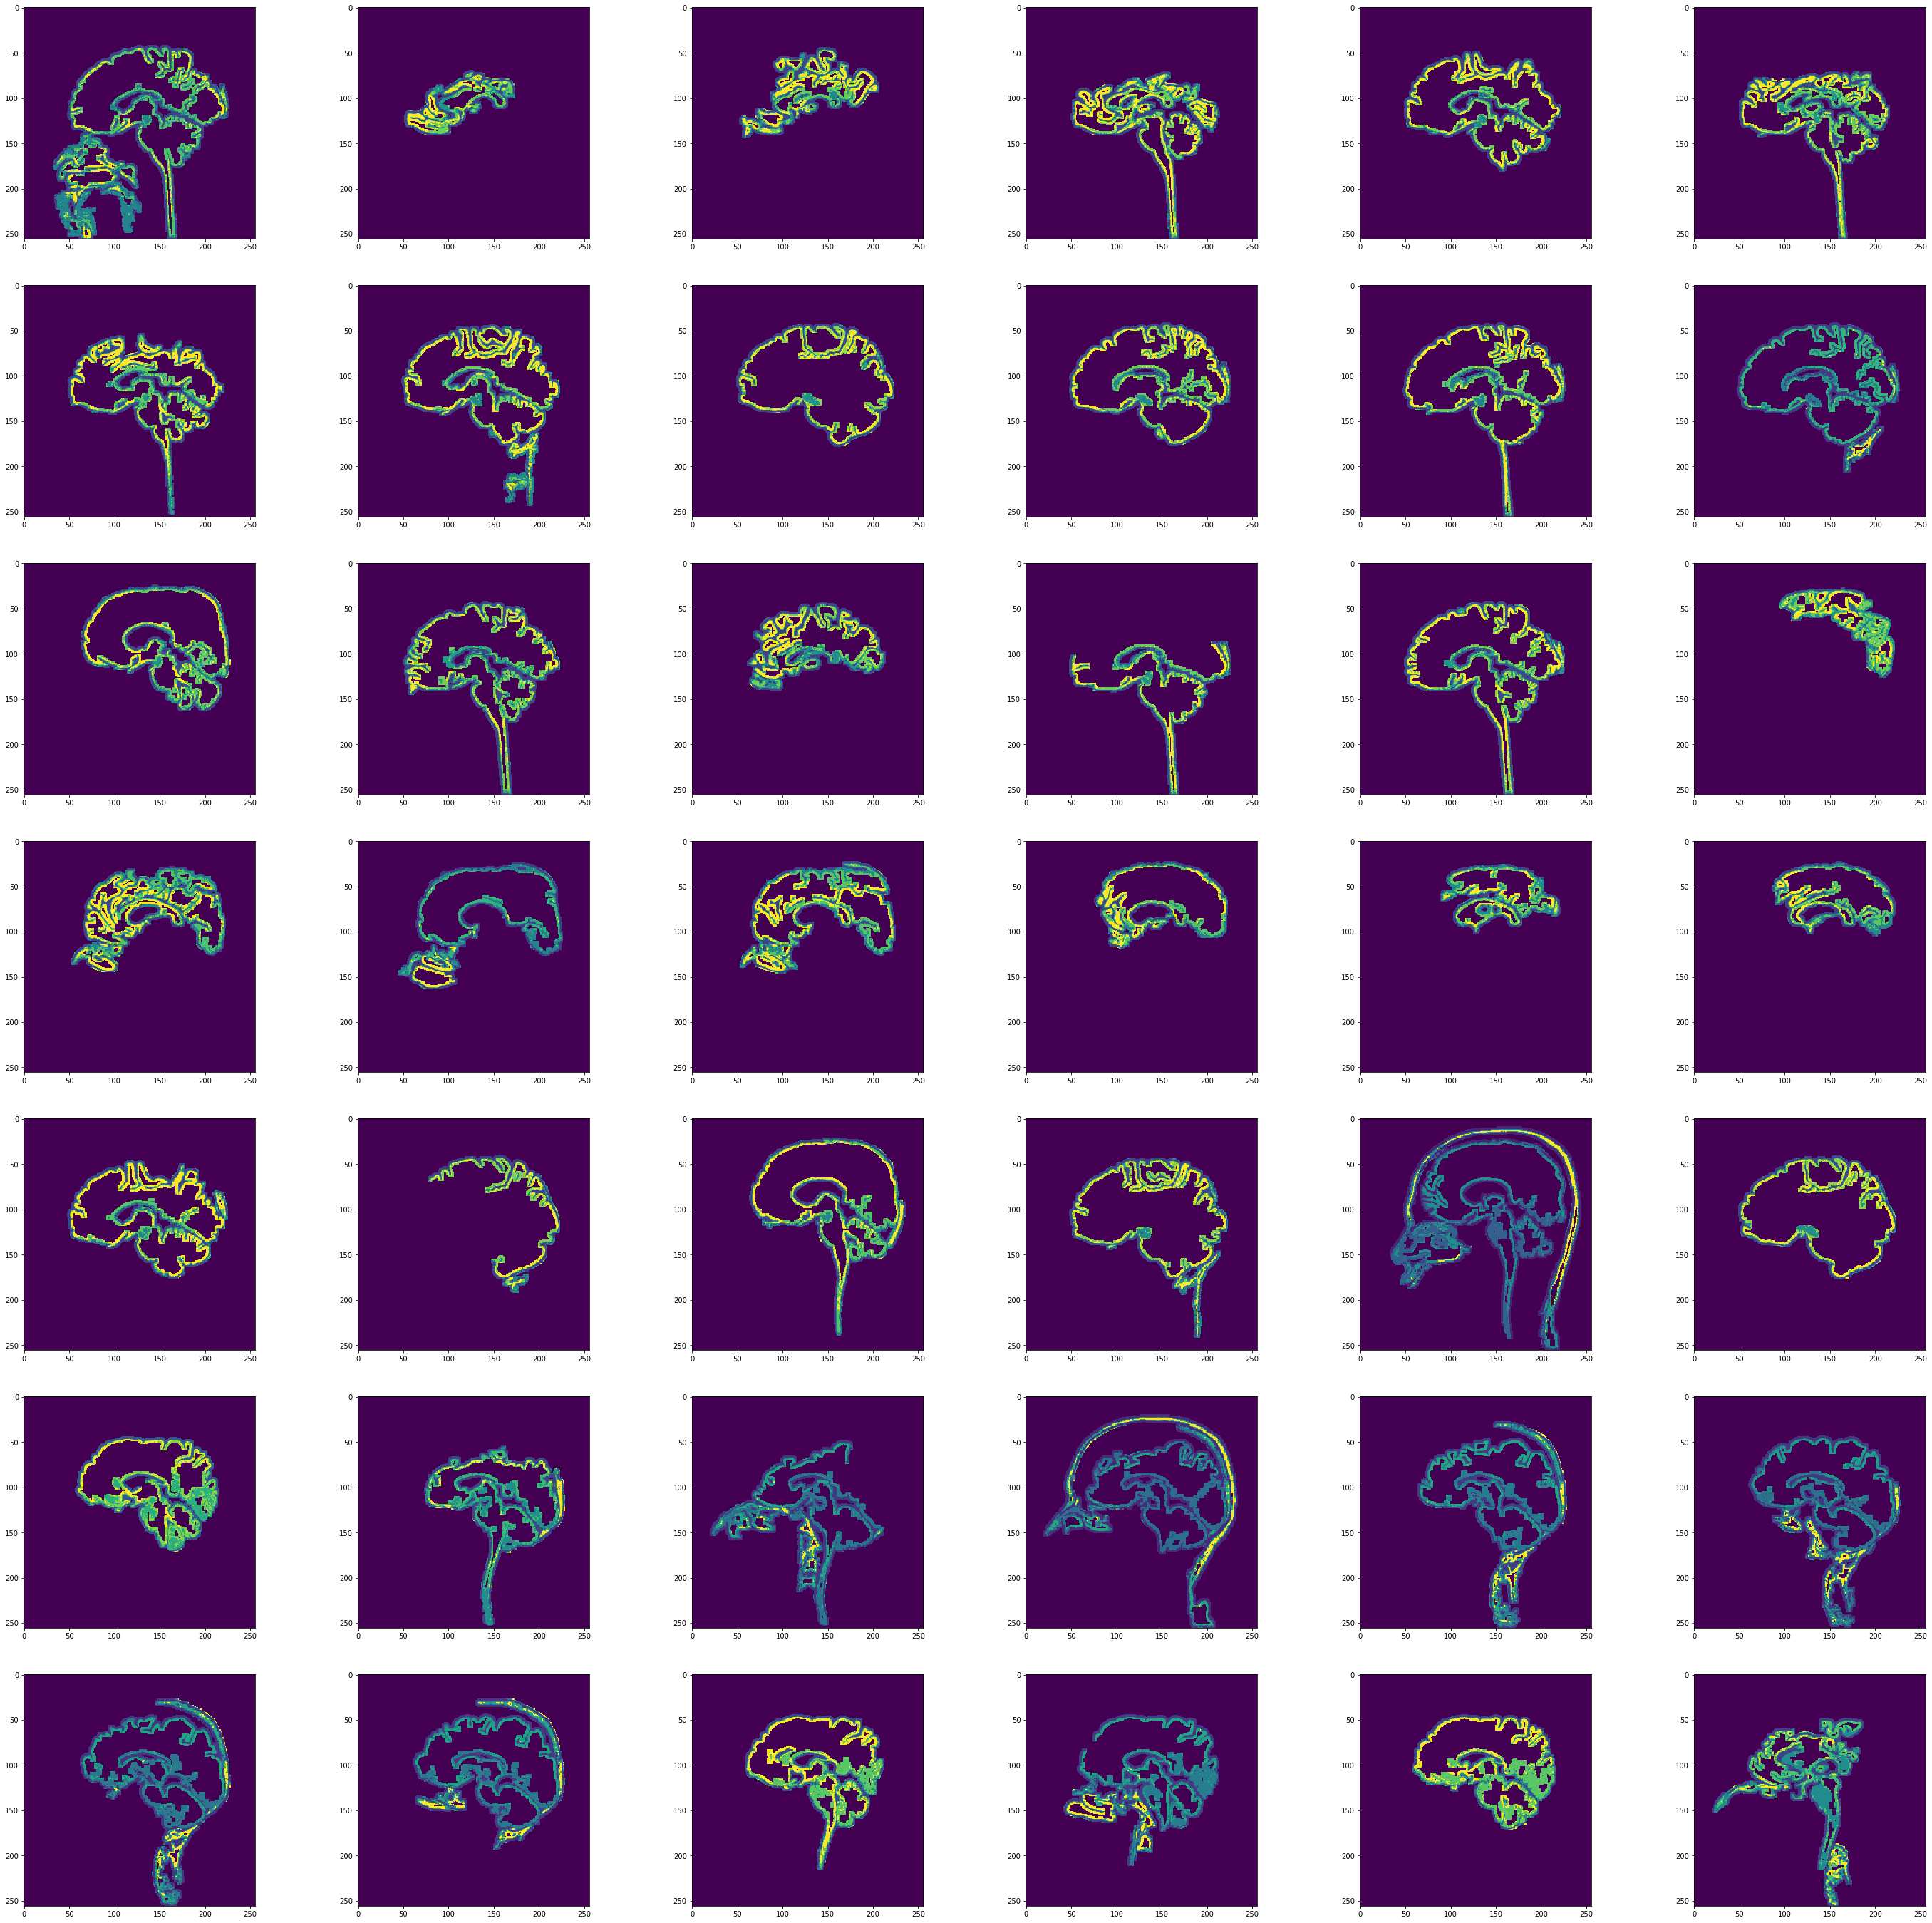

In [18]:
basepath ="../dicom/"
IMAGE_PATHS = os.listdir("../dicom/")
list_a = []

for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    
    #OTSU THRESHOLDING
    _,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    foreground_value = 255
    mask = np.uint8(binarized == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    binarized = np.zeros_like(binarized)
    binarized[labels == largest_label] = foreground_value
    
    edges = cv2.Canny(binarized,100,200)
    
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    foreground_value = 255
    mask = np.uint8(closing == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    closing = np.zeros_like(closing)
    closing[labels == largest_label] = foreground_value
    
    shape = np.ones((5, 5), np.uint8)
    dilation_close = cv2.dilate(closing,shape,iterations = 1)
    
    foreground_value = 255
    mask = np.uint8(dilation_close == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    dilation_close = np.zeros_like(dilation_close)
    dilation_close[labels == largest_label] = foreground_value

    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = dilation_close)
    brain_pixels = skull_stripped_image[dilation_close == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]
        
    segmented_image = np.zeros_like(dilation_close)
    segmented_image[dilation_close == foreground_value] = labels
    
    list_a.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_a[i])
plt.show()